In [1]:
# Changing learning rate

import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from dataset import AfricanWildlifeDataset
from loss import YoloLoss
from YOLOv1 import YOLO
from train import train
from test import test
from utils import plot_bbox, get_boxes
import time
from loss2 import Loss

# 1. Learning rate = 1e-5

In [2]:
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
torch.device('cuda')
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 5
EPOCHS = 20
TRAIN_DIR = 'African_Wildlife_augmented/train'
TEST_DIR = 'African_Wildlife_augmented/test'
LABEL_DIR = 'African_Wildlife_augmented/annotations'
VAL_DIR = 'African_Wildlife_augmented/val'
S, B, C = 7, 2, 4

In [3]:
# load the data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Normalize([0.5200, 0.4957, 0.4068],[0.2391, 0.2283, 0.2303])])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, VAL_DIR, LABEL_DIR, S=S, B=B, C=C, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

val_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, VAL_DIR, LABEL_DIR, S=S, B=B, C=C, isvalidation=True, transform=transform)
val_loader = DataLoader(dataset=val_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, VAL_DIR, LABEL_DIR, S=S, B=B, C=C, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1543
300
300
2144
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

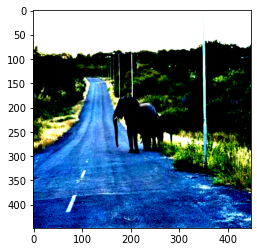

In [11]:
import os
import numpy as np


print(train_set.__len__())
print(test_set.__len__())
print(val_set.__len__())

print(len(os.listdir(LABEL_DIR)))

idx = 1 
val_img = val_set.__getitem__(idx)[0]
plt.imshow(  val_img.permute(1, 2, 0)  )

print(DEVICE)
print(torch.device('cuda')==DEVICE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

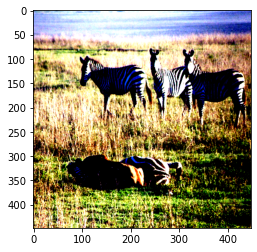

In [9]:
test_img  = test_set.__getitem__(idx)[0]
plt.imshow(  test_img.permute(1, 2, 0)  )
print(DEVICE)

## Training 

In [14]:
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=2)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = Loss(feature_size=S, num_bboxes=B, num_classes=C)
print(model)
model=model.to(torch.device('cuda'))

YOLO(
  (darknet): Sequential(
    (0): Sequential(
      (0): Convlayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.1)
      )
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Convlayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.1)
      )
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Convlayer(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
start_time = time.time()
loss_hist, val_hist = train(train_loader, val_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='learning_rates/lr1.tar', load_model=False, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 


In [ ]:
plt.plot(range(len(loss_hist)), loss_hist) # trained for 60 epochs
plt.plot(range(len(val_hist)), val_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Validation

In [ ]:
start_time = time.time()
val_loss_hist = val_train(val_loader, model, optimizer, criterion, 30, DEVICE, 
                  ckpt_filename='learning_rates/lr1.tar', load_model=True)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

In [ ]:
plt.plot(range(len(val_loss_hist)), val_loss_hist) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Testing

In [ ]:
loss_hist = train(train_loader, model, optimizer, criterion, 0, DEVICE, 
                  ckpt_filename='learning_rates/lr1.tar', load_model=True, 
                  save_epochs=5)

In [ ]:
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.60, True])

In [ ]:
color_map = {'buffalo': "red", 'elephant': "blue", 'rhino': "yellow", 'zebra': "green"}

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
for idx in range(50):
    bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

### Non-max-suppression

In [ ]:
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

In [ ]:
pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [ ]:
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])

##  Mean average precision

In [ ]:
def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [ ]:
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

In [ ]:
th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)

In [ ]:
m_ap.update(predictions, target)
ap = m_ap.compute()

In [ ]:
ap

# 2. Learning rate = 1e-6

In [ ]:
LEARNING_RATE = 1e-6
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

## Training

In [ ]:
start_time = time.time()
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='learning_rates/lr2.tar', load_model=False, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 

In [ ]:
plt.plot(range(len(loss_hist)), loss_hist) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Validation

In [ ]:
start_time = time.time()
val_loss_hist = val_train(val_loader, model, optimizer, criterion, 30, DEVICE, 
                  ckpt_filename='learning_rates/lr2.tar', load_model=True)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

In [ ]:
plt.plot(range(len(val_loss_hist)), val_loss_hist) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Testing

In [ ]:
loss_hist = train(train_loader, model, optimizer, criterion, 0, DEVICE, 
                  ckpt_filename='learning_rates/lr2.tar', load_model=True, 
                  save_epochs=5)

In [ ]:
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.60, True])

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
for idx in range(50):
    bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

### Non-max-suppression

In [ ]:
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

In [ ]:
pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

In [ ]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [ ]:
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])

## Mean Average Precision

In [ ]:
def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [ ]:
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)

m_ap.update(predictions, target)
ap = m_ap.compute()

In [ ]:
ap